<a href="https://colab.research.google.com/github/Guillem96/data2vec-vision/blob/main/data2vec_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data2Vec - Computer Vision

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt

import copy
import math
from typing import *
from pathlib import Path

import requests
from PIL import Image

## Download sample data

In [2]:
# !git clone https://github.com/Guillem96/optc-box-exporter

In [3]:
# !pip install -U --no-cache-dir gdown --pre

In [4]:
# %%shell
# cd optc-box-exporter/
# python -m optcbx download-portraits \
#     --units data/units.json \
#     --output data/Portraits

## Data2Vec package

In [5]:
def plot_patches(patches):
  plt.figure()
  cols, rows = patches.size(0), patches.size(1)
  for i in range(cols):
    for j in range(rows):
      plt.subplot(rows, cols, i * cols + j + 1)
      plt.imshow(F.to_pil_image(patches[i, j]))
      plt.axis("off")
  plt.subplots_adjust(wspace=0.05, hspace=.1)
  plt.show()

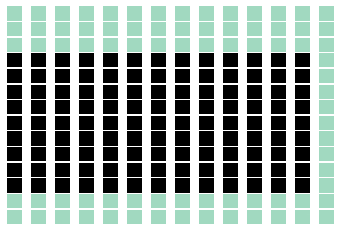

In [6]:
class ViTPatchesTransform(object):
  def __init__(self, patch_size: int = 16, patch_stride: int = 16) -> None:
    self.patch_size = patch_size
    self.patch_stride = patch_stride

  def __call__(self, im: torch.Tensor) -> torch.Tensor:
    """Extract patches from the given image as described in ViT paper.
    
    Args:
      im (torch.Tensor): Source image of shape (*, C, H, W) where * can be the
        batch.
    
    Returns:
      torch.Tensor: Image patches [*, K, C, PATCH_SIZE, PATCH_SIZE]
    """
    if im.dim() == 4:
      ix = (2, 3)
    elif im.dim() == 3:
      ix = (1, 2)
    else:
      raise ValueError("Invalid dimensions")

    patches = im
    for i in ix:
      patches = patches.unfold(i, self.patch_size, self.patch_stride)

    if im.dim() == 3:
      c = im.size(0)
      patches = patches.permute(1, 2, 0, 3, 4)
      return patches.reshape(-1, c, self.patch_size, self.patch_size)
    
    b, c, *_ = im.size()
    patches = patches.permute(0, 2, 3, 1, 4, 5)
    return patches.reshape(b, -1, c, self.patch_size, self.patch_size)

class BEiTMaskingTransform(object):
  def __init__(self, 
               p: float = 1.0, 
               patch_size: int = 16, 
               erase_pct: float = 0.6) -> None:
    self.erase_pct = erase_pct
    self.patch_size = patch_size
    self.rnd_erase_tfm = T.RandomErasing(p=p, 
                                         scale=(erase_pct, erase_pct), 
                                         ratio=(0.3, 3.3))

  def __call__(self, im: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    input_dim = im.dim()
    if input_dim == 4:
      np, _, h, w = im.size()
      bs = 1
    elif input_dim == 5:
      bs, np, _, h, w = im.size()
    else:
      raise ValueError("Unexpected dimension numbers {0}".format(input_dim))

    hnp = wnp = int(math.sqrt(np))
    masks = torch.ones(bs, 1, hnp, wnp)
    masks = self.rnd_erase_tfm(masks)
    exp_mask = masks.view(bs, 1, hnp, wnp, 1, 1)
    exp_mask = exp_mask.permute(0, 2, 3, 1, 4, 5)
    im = im.view(bs, hnp, wnp, 3, h, w) * exp_mask
    im = im.view(bs, hnp * wnp, 3, h, w)

    if input_dim == 4:
      return im.squeeze(), 1 - masks.view(hnp * wnp)

    return im, 1 - masks.view(bs, hnp * wnp)

tfm = T.Compose([T.Resize((224, 224)), 
                 T.ToTensor(),
                 ViTPatchesTransform(),
                 BEiTMaskingTransform()])

response = requests.get("https://lh3.googleusercontent.com/kU1dgUjAYxn5vJB8mOGDD_ViOs4gFDKfG0-PvHMryf4AJ6i0q_0-vKF8apQp99p6eaXt5Sx577NXZ1kdvtsXViOZlA=w640-h400-e365-rj-sc0x00ffffff", stream=True)
im = Image.open(response.raw)
erased_im = tfm(im)
plot_patches(erased_im[0].view(14, 14, 3, 16, 16))

In [7]:
@torch.no_grad()
def _generate_targets(model: nn.Module, 
                      inputs: torch.Tensor, 
                      k: int = 4) -> torch.Tensor:
  # Generate the targets in teacher mode
  model.eval()
  _, hidden_states = model(inputs)
  top_k_hs = torch.stack(hidden_states[-k:])  # [K, N, L, C]

  # Prepare tensor for instance_norm function
  k, n, l, c = top_k_hs.size()
  top_k_hs = top_k_hs.view(-1, l, c) # [K * N, L, C]
  top_k_hs = top_k_hs.permute(0, 2, 1)  # [K * N, C, L]
  top_k_hs = nn.functional.instance_norm(top_k_hs)

  # Get back to expected shape
  top_k_hs = top_k_hs.view(k, n, c, l)  # [K, N, C, L]
  top_k_hs = top_k_hs.permute(0, 1, 3, 2)  # [K, N, L, C]

  # Average the K blocks
  return top_k_hs.mean(0)


def train_step(teacher_model: nn.Module,
               student_model: nn.Module,
               im: torch.Tensor,
               masked_im: torch.Tensor,
               bool_mask: torch.Tensor,
               k: int = 3,
               beta: float = 1.0) -> float:
  """Single training step.
  
  Args:
    model (nn.Module): Data2Vec model.
    im (torch.Tensor): Input image for the teacher model to generate the 
      targets. Tensor shape [N, T, H]
    masked_im (torch.Tenosr): Randomly masked image. Input for the student
      model. Tensor shape [N, T, H]
    k (int): Regress the last k hidden states average. Defaults 3.
    beta (float): Beta for the smooth l1 loss. Defaults 1.0.
  
  Returns:
    float: Loss
  """
  y = _generate_targets(teacher_model, im, k=k)
  x, _ = student_model(masked_im)

  x = x[bool_mask.long()]
  y = y[bool_mask.long()]

  loss = nn.functional.smooth_l1_loss(x, y, reduction="none", beta=beta).sum() / math.sqrt(x.size(-1))
  loss.backward()

  return loss.item()

Sample = Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]


def update_model_params(model: nn.Module, new_params: Iterator[Tuple[str, torch.Tensor]], tau: float) -> None:
  for (n, p), (n1, p1) in zip(model.named_parameters(), new_params):
    assert n == n1
    p.data.copy_(tau * p.data + (1 - tau) * p1.data)


def tau_generator(min_value: float = .2, max_value: float = .7, increase_steps: int = 512) -> Iterator[float]:
  step = 0
  slope = (max_value - min_value) / increase_steps
  while True:
    if step < increase_steps:
      yield step * slope + min_value
      step += 1
    else:
      yield max_value

def train_single_epoch(teacher_model: nn.Module,
                       student_model: nn.Module,
                       dl: Iterator[Sample], 
                       optimizer: torch.optim.Optimizer,
                       lr_scheduler: torch.optim.lr_scheduler._LRScheduler,
                       tau_gen: Iterator[float],
                       epoch: int,
                       k: int = 3,
                       beta: float = 1.0, 
                       device: torch.device = torch.device("cpu")) -> None:
  running_loss = 0
  student_model.train()

  for i, (im, (masked_im, bool_mask)) in enumerate(dl, start=1):
    im = im.to(device)
    masked_im = masked_im.to(device)
    bool_mask = bool_mask.to(device)

    optimizer.zero_grad()
    running_loss += train_step(teacher_model, student_model, im, masked_im, bool_mask, k=k, beta=beta)
    nn.utils.clip_grad_norm_(student_model.parameters(), 5.0)
    optimizer.step()
    lr_scheduler.step()

    update_model_params(teacher_model, student_model.named_parameters(), next(tau_gen))
    if i % 30 == 0:
      loss_mean = running_loss / i
      print(f"Epoch [{epoch}] loss: {loss_mean:.4f}")


In [8]:
class PositionalEmbedding1D(nn.Module):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, seq_len: int, dim: int):
    super().__init__()
    self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
  def forward(self, x):
    """Input has shape `(batch_size, seq_len, emb_dim)`"""
    return x + self.pos_embedding


class Data2Vec(nn.Module):
  def __init__(self, 
               patch_size: int, 
               seq_len: int, 
               dim: int = 768, 
               nhead: int = 8, 
               n_encoders: int = 8) -> None:
    super().__init__()
    el = nn.TransformerEncoderLayer(dim, nhead=nhead, dim_feedforward=dim * 4)
    self.encoder = nn.TransformerEncoder(el, n_encoders)
    self.patch_linear = nn.Linear(patch_size * patch_size * 3, dim)
    self.pos_embedding = PositionalEmbedding1D(seq_len, dim)
    self.regessor = nn.Linear(dim , dim)

    self.hs = []
    for l in self.encoder.layers:
      l.dropout2.register_forward_hook(self._register_hs_hook)

  def _register_hs_hook(self, layer: nn.Module, inputs: torch.Tensor, outputs: torch.Tensor) -> None:
    self.hs.append(outputs)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    self.hs.clear()
    x = self.patch_linear(x)
    x = self.pos_embedding(x)
    x = self.encoder(x)
    return self.regessor(x), [h.clone() for h in self.hs]

## Datasets definition

In [9]:
class Data2VecDataset(torch.utils.data.Dataset):

  def __init__(self, paths, masking_fn, transforms=None):
    self.paths = paths
    self.transforms = transforms
    self.masking_fn = masking_fn

  def __getitem__(self, idx):
    im = Image.open(self.paths[idx]).convert('RGB')

    if self.transforms is not None:
      im = self.transforms(im)
    
    masked_im = self.masking_fn(im)

    return im.view(14 * 14, 16 * 16 * 3), (masked_im[0].view(14 * 14, 16 * 16 * 3), masked_im[1])
  
  def __len__(self):
    return len(self.paths)

train_tfm = T.Compose([T.Resize((256, 256)),
                       T.RandomCrop((224, 224)),
                       T.ColorJitter(brightness=.5, hue=.3),
                       T.ToTensor(),
                       ViTPatchesTransform()])

test_tfm = T.Compose([T.Resize((256, 256)),
                      T.CenterCrop((224, 224)),
                      T.ToTensor(),
                      ViTPatchesTransform()])

masking_tfm = BEiTMaskingTransform(erase_pct=.4)

In [10]:
paths = list(Path('/content/optc-box-exporter/data/Portraits').glob('*.png'))
train_ds = Data2VecDataset(paths, masking_fn=masking_tfm, transforms=train_tfm)
valid_ds = Data2VecDataset(paths, masking_fn=masking_tfm, transforms=test_tfm)

ds_len = len(train_ds)
train_ds_len = int(ds_len * .8)
valid_ds_len = ds_len - train_ds_len

rand_idx = torch.randperm(ds_len)
train_ds = torch.utils.data.Subset(train_ds, rand_idx[:train_ds_len])
valid_ds = torch.utils.data.Subset(valid_ds, rand_idx[train_ds_len:])

train_dl = torch.utils.data.DataLoader(
    train_ds, 
    16,
    True,
    pin_memory=True)

valid_dl = torch.utils.data.DataLoader(
    valid_ds, 
    32,
    False,
    pin_memory=True)

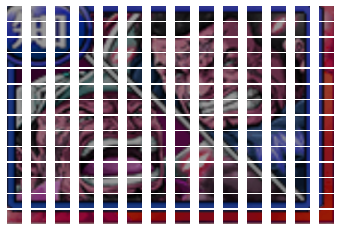

In [ ]:
im, (masked_im, mask) = train_ds[torch.randint(0, len(train_ds), size=(1,)).item()]
plot_patches(im.view(14, 14, 3, 16, 16))
plot_patches(masked_im.view(14, 14, 3, 16, 16))

In [ ]:
import random

@torch.no_grad()
def one_shot_task(paths, model):
  model.eval()
  target_path = random.choice(paths)
  other_paths = random.sample(paths, 14)
  other_paths += [target_path, target_path]

  images = [Image.open(o).convert('RGB') for o in other_paths]
  images = torch.stack([train_tfm(o) for o in images]).view(16, 14 * 14, 16 * 16 * 3)
  reprs, _ = model(images.to(device))
  reprs = reprs.mean(1)
  similarities = nn.functional.cosine_similarity(reprs.unsqueeze(1), 
                                                 reprs.unsqueeze(0),
                                                 dim=-1)
  
  print(similarities)

# one_shot_task(paths, student_model

## Training!

In [ ]:
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_model = Data2Vec(patch_size=16, seq_len=14 * 14, n_encoders=4)
student_model.to(device)

teacher_model = copy.deepcopy(student_model)
teacher_model.to(device)

optimizer = torch.optim.Adam(params=student_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=1e-1, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=len(train_dl),
                                                anneal_strategy="cos")
tau_gen = tau_generator(max_value=0.99)
for epoch in range(EPOCHS):
  train_single_epoch(teacher_model, 
                     student_model, 
                     dl=train_dl, 
                     optimizer=optimizer, 
                     lr_scheduler=scheduler, 
                     tau_gen=tau_gen, 
                     epoch=epoch, 
                     device=device, 
                     k=2, beta=2)